In [1]:
# both can change
# Environment
import numpy as np
import pandas as pd
from MesoPy import Meso
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt
import tensorflow as tf
import keras.backend as K
from keras.utils.vis_utils import plot_model
from scipy.interpolate import LinearNDInterpolator, interpn
from scipy.optimize import root

# Local modules for handling data and running moisture models
import data_funcs as datf
from data_funcs import format_raws, retrieve_raws, format_precip, fixnan
import moisture_models as mod
from moisture_rnn import create_RNN_2, staircase, create_rnn_data, train_rnn, rnn_predict

meso_token="b40cb52cbdef43ef81329b84e8fd874f"
m=Meso(meso_token)

2023-01-05 23:37:30.585032: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Calculate mean squared error
def mse(a, b):
    return ((a - b)**2).mean()
# Calculate mean absolute error
def mape(a, b):
    return ((a - b).__abs__()).mean()

In [3]:
def vprint(*args):
    if verbose: 
        for s in args[:(len(args)-1)]:
            print(s, end=' ')
        print(args[-1])

## Validation Setup

In [4]:
time_start = "201806010800"
hours = 1200 # total simulation time
time_end = datetime.strptime(time_start, "%Y%m%d%H%M")+timedelta(hours = hours+1) # end time, plus a buffer to control for time shift
time_end = str(int(time_end.strftime("%Y%m%d%H%M")))
h2 = 300 # training period
train_hrs = np.arange(0, h2) # training time
test_hrs = np.arange(h2, hours) # forecast time

print('Time Parameters:')
print('-'*50)
print('Time Start:', datetime.strptime(time_start, "%Y%m%d%H%M").strftime("%Y/%M/%d %H:%M"))
print('Time End:', datetime.strptime(time_end, "%Y%m%d%H%M").strftime("%Y/%M/%d %H:%M"))
print('Total Runtime:', hours, 'hours')
print('Training Time:', h2, 'hours')
print('-'*50)

Time Parameters:
--------------------------------------------------
Time Start: 2018/00/01 08:00
Time End: 2018/00/21 09:00
Total Runtime: 1200 hours
Training Time: 300 hours
--------------------------------------------------


## Retrieve RAWS Data

In [5]:
raws_vars='air_temp,relative_humidity,precip_accum,fuel_moisture'

In [6]:
station, raws_dat = retrieve_raws(m, "BKCU1", raws_vars, time_start, time_end)

In [7]:
def plot_dat(stn, dat, val):
    plt.figure(figsize=(16,4))
    plt.plot(dat[val],linestyle='-',c='k')
    plt.title(stn['STID']+' '+ val)
    plt.xlabel('Time (hours)') 
    plt.ylabel('val')

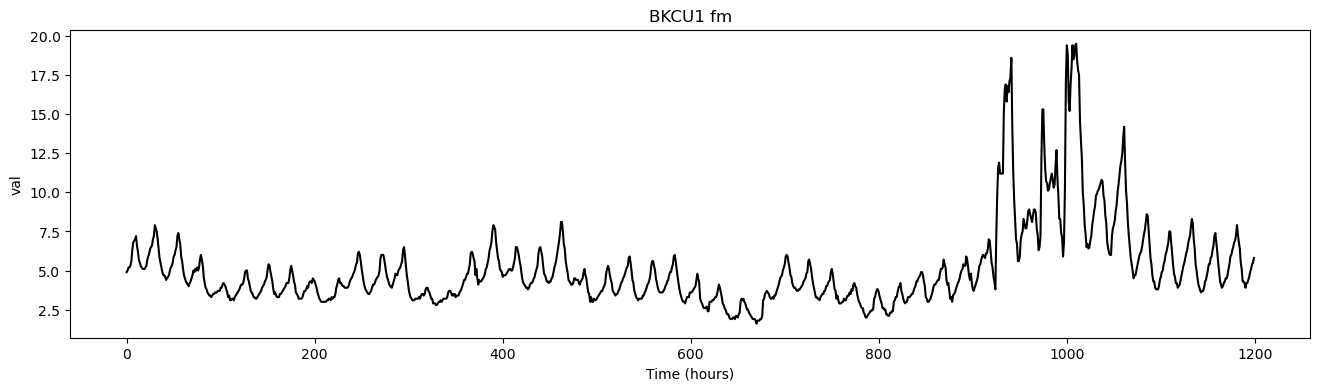

In [8]:
%matplotlib inline
plot_dat(station, raws_dat, 'fm')

In [9]:
print('Data Read:')
print('-'*50)
print('Station ID:', station['STID'])
print('Lat / Lon:', station['LATITUDE'],', ',station['LONGITUDE'])
if(station['QC_FLAGGED']): print('WARNING: station flagged for QC')
print('-'*50)

Data Read:
--------------------------------------------------
Station ID: BKCU1
Lat / Lon: 38.979242 ,  -112.238864
--------------------------------------------------


## Retrieve RTMA Function

<mark>Not needed?</mark>

## Interface
Jonathon changes above  create each case as a dictionary, then dictionary of dictionaries, figure out how to store and load dictionaries as a file. json is possible but: cannot contain datetime objects
look into pickle also compresses while json is plain text clone wrfxpy look how for idioms, pickle added jan/angel lager
Jan will edit from here below. 
cases will be extracted from dictionary as global variables for now at least

In [11]:
# dictionary raws_dat has all that is needed for the run 
# keeping the name raws_dat for now even if it may not be raws data
from data_utils import check_data
check_data(raws_dat,h2,hours)
    
    

IndentationError: unindent does not match any outer indentation level (data_utils.py, line 5)

## Fit Augmented KF

In [12]:
m,Ec = mod.run_augmented_kf(raws_dat['fm'],raws_dat['Ed'],raws_dat['Ew'],raws_dat['rain'],h2,hours)  # extract from state

In [13]:
def plot_moisture(hmin,hmax):
    print('training from 0 to',h2,'plot from',hmin,'to',hmax)
    plt.figure(figsize=(16,4))
    plt.plot(range(hmin,hmax),raws_dat['Ed'][hmin:hmax],linestyle='--',c='r',label='Drying Equilibrium (%)')
    plt.plot(range(hmin,hmax),raws_dat['Ew'][hmin:hmax],linestyle='--',c='b',label='Wetting Equilibrium (%)')
    plt.plot(range(hmin,hmax),Ec[hmin:hmax],linestyle='--',c='g',label='Equilibrium Correction (%)')
    plt.plot(range(hmin,hmax),m[hmin:hmax],linestyle='-',c='k',label='filtered')
    plt.plot(range(hmin,hmax),raws_dat['fm'][hmin:hmax],linestyle='-',c='b',label='RAWS data (%)')
    plt.plot(range(hmin,hmax),raws_dat['rain'][hmin:hmax],linestyle='-',c='b',label='RTMA rain (mm/h)')
    if hmin>=h2:
        plt.plot(m[hmin:h2],linestyle='-',c='k',label='Filtered')
    h1 = np.maximum(hmin,h2)
    plt.plot(range(h1,hmax),m[h1:hmax],linestyle='-',c='r',label='Forecast (%)')
    plt.title(station['STID'] +' Kalman filtering and forecast with augmented state, real data. Training 0:%i hmax' % h2)
    plt.xlabel('Time (hours)') 
    plt.ylabel('Fuel moisture content (%)')
    plt.legend()

In [ ]:
plot_moisture(0, hours)

In [ ]:
# Forecast Error
print('Forecast MSE: ' + str(np.round(mse(m[h2:hours], raws_dat['fm'][h2:hours]), 4)))

## Fit RNN Model

In [ ]:
# Set seed for reproducibility
tf.random.set_seed(123)

In [ ]:
verbose = False
scale = False
rnn_dat = create_rnn_data(raws_dat, hours, h2, scale)

In [ ]:
model_predict = train_rnn(
    rnn_dat,
    hours,
    activation=['linear','linear'],
    hidden_units=3,
    dense_units=1,
    dense_layers=1,
    verbose = verbose
)

In [ ]:
verbose = 0
m = rnn_predict(model_predict, rnn_dat, hours)

In [ ]:
hour=np.array(range(hours))
title="RNN forecast"
plt.figure(figsize=(16,4))
plt.plot(hour,rnn_dat['Et'][:,0],linestyle='--',c='r',label='E=Equilibrium data')
# print(len(hour),len(m_f))
plt.plot(hour,raws_dat['fm'],linestyle='-',c='b',label='data')
# plt.scatter(hour,raws_dat['fm'],c='b',label='data=10-h fuel data')
if m is not None:
    plt.plot(hour[:h2],m[:h2],linestyle='-',c='k',label='m=filtered')
    plt.plot(hour[h2:hours],m[h2:hours],linestyle='-',c='r',label='m=forecast')
plt.title(title) 
plt.legend()

In [ ]:
# Overall Error
print(mse(m, raws_dat['fm'][0:hours]))

# Forecast Eror
print(mse(m[h2:hours], raws_dat['fm'][h2:hours]))